## Likelihood-free inference in non-Gaussian stochastic volatility models

This tutorial

In [1]:
import os
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro import poutine
from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']

In [2]:
df = pd.read_csv(os.path.expanduser("~/Downloads/snp500.csv"))

In [3]:
x = torch.tensor(df["Open"]).float()
torch.save(x, os.path.expanduser("~/Downloads/snp500_daily_open.pkl"))

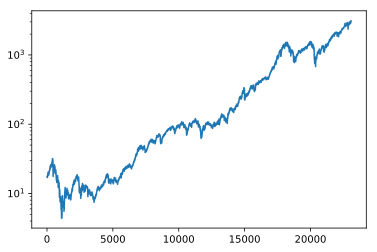

In [4]:
pyplot.plot(x)
pyplot.yscale('log')

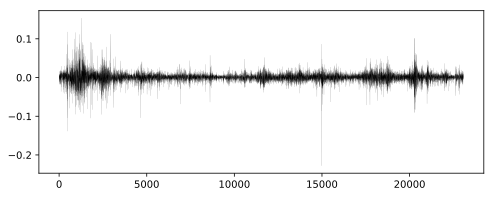

In [5]:
pyplot.figure(figsize=(8, 3), dpi=300)
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1);

mean = 0.00022400928719434887
std = 0.011747308075428009


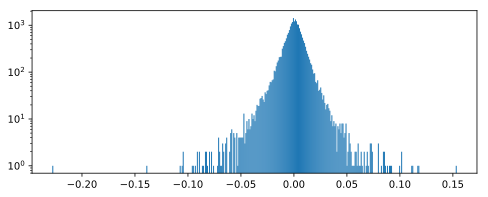

In [6]:
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(r, bins=400)
pyplot.yscale('log')
print("mean = {}".format(r.mean()))
print("std = {}".format(r.std()))

First let's fit a single distribution to the returns.

In [7]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = pyro.param("skew", torch.tensor(0.), constraint=constraints.interval(0, 2))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 81.07508850097656
step 40 loss = 2.9748997688293457
step 80 loss = 1.5711004734039307
step 120 loss = 1.4062905311584473
step 160 loss = 1.3863089084625244
step 200 loss = 1.3112322092056274
step 240 loss = 1.2798806428909302
step 280 loss = 1.274643898010254
loc = 0.0005769712151959538
scale = 0.01011065673083067
skew = 2.350988701644575e-38
stability = 1.9863886833190918
CPU times: user 31.2 s, sys: 846 ms, total: 32.1 s
Wall time: 4.76 s


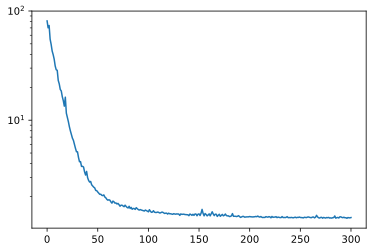

In [8]:
%%time
from pyro.infer import SVI, Trace_CRPS
from pyro.optim import ClippedAdam

pyro.clear_param_store()
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 301
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, Trace_CRPS())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 40 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

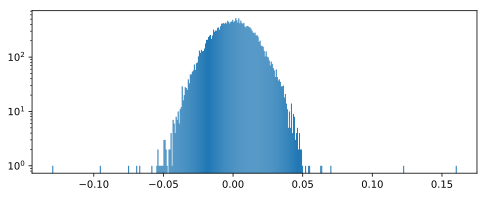

In [9]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(samples, bins=400)
pyplot.yscale('log')

This is a poor fit, but that's to be expected since we're mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, StudentT, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling in Pyro

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to Student t and Stable distributions.

In [10]:
class Process(dist.TorchDistribution):
    arg_constraints = {}
    def __init__(self, size, decay, trans_dist):
        self.decay = decay
        self.trans_dist = trans_dist
        batch_shape = trans_dist.batch_shape
        event_shape = (size,)
        super().__init__(batch_shape, event_shape)
    @property
    def support(self):
        return self.trans_dist.support
    def expand(self, shape):
        return Process(
            self.event_shape[0],
            self.decay,
            self.trans_dist.expand(shape))
    def log_prob(self, series):
        # Effectively unsqueeze self.trans_dist
        if isinstance(self.trans_dist, dist.Normal):
            trans_dist = dist.Normal(self.trans_dist.loc.unsqueeze(-1),
                                     self.trans_dist.scale.unsqueeze(-1))
        elif isinstance(self.trans_dist, dist.StudentT):
            trans_dist = dist.StudentT(self.trans_dist.df.unsqueeze(-1),
                                       self.trans_dist.loc.unsqueeze(-1),
                                       self.trans_dist.scale.unsqueeze(-1))
        else:
            raise NotImplementedError(type(self.trans_dist))
        diff = series[:-1] - series[1:] * self.decay
        return trans_dist.log_prob(diff).sum(-1)

class Model:
    def __init__(self, process_type="normal", obs_type="normal"):
        self.process_type = process_type
        self.obs_type = obs_type
        
    def __call__(self, data):
        # We experiment with three types of process noise.
        h_loc = pyro.sample("h_loc", dist.Normal(0, 1))
        h_decay = pyro.sample("h_decay", dist.Uniform(0, 1))
        h_scale = pyro.sample("h_scale", dist.LogNormal(-10, 3))
        if self.process_type == "normal":
            h_dist = dist.Normal(h_loc * (1 - h_decay), h_scale)
        elif self.process_type == "studentt":
            h_df = pyro.sample("h_df", dist.Gamma(3, 1))
            h_dist = dist.StudentT(h_df, h_loc * (1 - h_decay), h_scale)
        else:
            raise ValueError("unsupported process_type: {}".format(self.process_type))
        log_h = pyro.sample("log_h", Process(len(data), h_decay, h_dist))
        if log_h.dim() >= 2:
            log_h = log_h.squeeze(-2)
        sqrt_h = log_h.mul(0.5).exp()

        # We experiment with two types of observation noise.
        r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2))
        if self.obs_type == "normal":
            r_dist = dist.Normal(r_loc, sqrt_h)
        elif self.obs_type == "studentt":
            r_df = pyro.sample("r_df", dist.Gamma(3, 1))
            r_dist = dist.StudentT(r_df, r_loc, sqrt_h)
        elif self.obs_type == "stable":
            r_stability = pyro.sample("r_stability", dist.Uniform(0.5, 2.0))
            r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1))
            r_dist = dist.Stable(r_stability, r_skew, sqrt_h, r_loc)
        else:
            raise ValueError("unsupported obs_type: {}".format(self.obs_type))
        with pyro.plate("time", len(data)):
            r = pyro.sample("r", r_dist, obs=data)

        return log_h.detach(), r.detach()

In [11]:
from pyro.infer.autoguide import AutoDelta
from pyro.infer.autoguide import init_to_feasible

def init_loc_fn(site):
    inits = {
        "h_loc": torch.tensor(0.),
        "h_decay": torch.tensor(0.9),
        "h_df": torch.tensor(10.),
        "h_scale": torch.tensor(1e-2),
        "r_df": torch.tensor(10.),
        "r_stability": torch.tensor(1.9),
        "r_skew": torch.tensor(0.),
        "r_loc": torch.tensor(0.),
    }
    if site["name"] in inits:
        return inits[site["name"]]
    return init_to_feasible(site)

In [12]:
from pyro.infer import SVI, Trace_CRPS, Trace_ELBO
from pyro.optim import ClippedAdam

def train(model, guide, optim, loss):
    svi = SVI(model, guide, optim, loss)
    losses = []
    for step in range(401):
        loss = svi.step(r)
        losses.append(loss)
        if step % 20 == 0:
            print("step {} loss = {}".format(step, loss))
    for name, value in sorted(guide.median().items()):
        if value.numel() == 1:
            print("{} = {}".format(name, value.squeeze().item()))
    pyplot.plot(losses)

In [13]:
from pyro import poutine

@torch.no_grad()
def predict(model, guide, data):
    trace = poutine.trace(guide).get_trace(data)
    with poutine.replay(trace=trace), poutine.uncondition():
        return model(data)

predictions = {}

def add_prediction(model, guide, data):
    predictions[model.process_type, model.obs_type] = predict(model, guide, data)

step 0 loss = -63873.69895040989
step 40 loss = -71902.6414578557
step 80 loss = -79506.98462945223
step 120 loss = -84157.79985922575
step 160 loss = -84671.02754867077
step 200 loss = -84677.46921157837
step 240 loss = -84546.63796204329
step 280 loss = -84604.90833747387
step 320 loss = -84576.09603095055
step 360 loss = -84595.96617883444
step 400 loss = -84923.14192992449
h_decay = 0.934417188167572
h_loc = -0.018661905080080032
h_scale = 0.0024702376686036587
r_loc = -0.00014953615027479827
CPU times: user 2.71 s, sys: 62 ms, total: 2.77 s
Wall time: 2.79 s


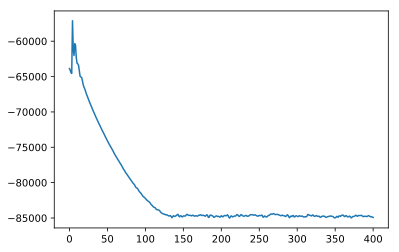

In [14]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
model = Model("normal", "normal")
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
svi = SVI(model, guide, ClippedAdam({"lr": 0.01}), Trace_ELBO())
losses = []
for step in range(401):
    loss = svi.step(r)
    losses.append(loss)
    if step % 40 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))
add_prediction(model, guide, r)

step 0 loss = -63291.33167660236
step 40 loss = -71522.50226050615
step 80 loss = -79316.04093158245
step 120 loss = -84113.29927313328
step 160 loss = -84629.76295036077
step 200 loss = -84633.84807950258
step 240 loss = -84568.493691504
step 280 loss = -84644.75187963247
step 320 loss = -84403.09337598085
step 360 loss = -84563.76168465614
step 400 loss = -84426.00660032034
h_decay = 0.9468142986297607
h_loc = -0.01912412792444229
h_scale = 0.0024965654592961073
r_df = 76.99253845214844
r_loc = 0.003828790271654725
CPU times: user 3.55 s, sys: 163 ms, total: 3.71 s
Wall time: 3.65 s


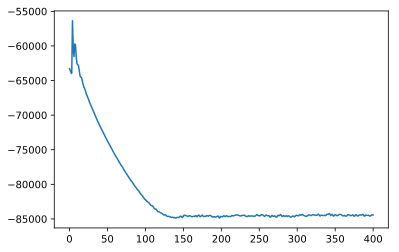

In [15]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
model = Model("normal", "studentt")
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
svi = SVI(model, guide, ClippedAdam({"lr": 0.01}), Trace_ELBO())
losses = []
for step in range(401):
    loss = svi.step(r)
    losses.append(loss)
    if step % 40 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))
add_prediction(model, guide, r)

step 0 loss = -63291.29066097736
step 40 loss = -71416.07536816597
step 80 loss = -79105.49395048618
step 120 loss = -84134.12577068806
step 160 loss = -84818.5647470355
step 200 loss = -84955.04857832193
step 240 loss = -84764.76278215647
step 280 loss = -84665.03452938795
step 320 loss = -84742.62320405245
step 360 loss = -84765.73215538263
step 400 loss = -84837.41461336613
h_decay = 0.929241418838501
h_df = 29.06247901916504
h_loc = -0.014997057616710663
h_scale = 0.002395340707153082
r_loc = -0.00046105351066216826
CPU times: user 2.93 s, sys: 106 ms, total: 3.04 s
Wall time: 3.01 s


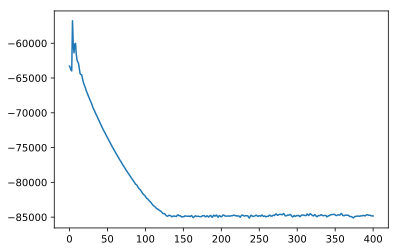

In [16]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
model = Model("studentt", "normal")
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
svi = SVI(model, guide, ClippedAdam({"lr": 0.01}), Trace_ELBO())
losses = []
for step in range(401):
    loss = svi.step(r)
    losses.append(loss)
    if step % 40 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))
add_prediction(model, guide, r)

step 0 loss = -62708.92338716984
step 40 loss = -71017.80191296339
step 80 loss = -78900.89327609539
step 120 loss = -83889.66993844509
step 160 loss = -84182.65389537811
step 200 loss = -84490.1838234663
step 240 loss = -84591.88722336292
step 280 loss = -84558.92643791437
step 320 loss = -84638.40732890368
step 360 loss = -84577.83245754242
step 400 loss = -84698.32263445854
h_decay = 0.9200457334518433
h_df = 30.133872985839844
h_loc = -0.017064852640032768
h_scale = 0.0023913453333079815
r_df = 76.97451782226562
r_loc = 0.003828790271654725
CPU times: user 4.16 s, sys: 231 ms, total: 4.39 s
Wall time: 4.34 s


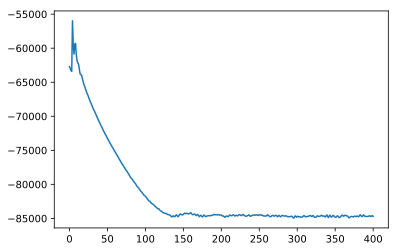

In [17]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
model = Model("studentt", "studentt")
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
svi = SVI(model, guide, ClippedAdam({"lr": 0.01}), Trace_ELBO())
losses = []
for step in range(401):
    loss = svi.step(r)
    losses.append(loss)
    if step % 40 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))
add_prediction(model, guide, r)

step 0 loss = 81.07508850097656
step 20 loss = 32.339202880859375
step 40 loss = 12.43705940246582
step 60 loss = 8.068397521972656
step 80 loss = 6.208744049072266
step 100 loss = 5.12556266784668
step 120 loss = 4.622204780578613
step 140 loss = 3.911015510559082
step 160 loss = 3.4683332443237305
step 180 loss = 3.203885078430176
step 200 loss = 3.044139862060547
step 220 loss = 2.6861257553100586
step 240 loss = 2.5719618797302246
step 260 loss = 2.614090919494629
step 280 loss = 2.3870062828063965
step 300 loss = 2.341702938079834
step 320 loss = 2.265479564666748
step 340 loss = 2.158428192138672
step 360 loss = 2.2036209106445312
step 380 loss = 2.1370630264282227
step 400 loss = 2.179586410522461
h_decay = 0.8999999761581421
h_loc = 0.0
h_scale = 0.009999999776482582
r_loc = 2.0174782548565418e-05
r_skew = 0.8789249658584595
r_stability = 1.999695062637329
CPU times: user 40.3 s, sys: 2.17 s, total: 42.5 s
Wall time: 6.9 s


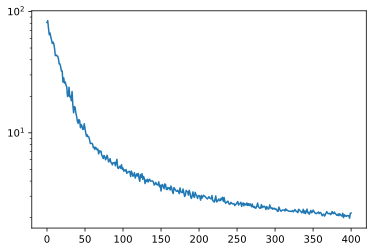

In [18]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
model = Model("normal", "stable")
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
num_steps = 401
optim = ClippedAdam(lambda name, _: {
    "lr": 0.5 if name.startswith("Auto") else 0.02,
    "lrd": 0.1 ** (1 / num_steps),
})
svi = SVI(model, guide, optim, Trace_CRPS())
losses = []
for step in range(num_steps):
    loss = svi.step(r)
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))
add_prediction(model, guide, r)

step 0 loss = 81.07508850097656
step 20 loss = 32.339202880859375
step 40 loss = 12.43705940246582
step 60 loss = 8.068397521972656
step 80 loss = 6.208744049072266
step 100 loss = 5.12556266784668
step 120 loss = 4.622204780578613
step 140 loss = 3.911015510559082
step 160 loss = 3.4683332443237305
step 180 loss = 3.203885078430176
step 200 loss = 3.044139862060547
step 220 loss = 2.6861257553100586
step 240 loss = 2.5719618797302246
step 260 loss = 2.614090919494629
step 280 loss = 2.3870062828063965
step 300 loss = 2.341702938079834
step 320 loss = 2.265479564666748
step 340 loss = 2.158428192138672
step 360 loss = 2.2036209106445312
step 380 loss = 2.1370630264282227
step 400 loss = 2.179586410522461
h_decay = 0.8999999761581421
h_df = 10.0
h_loc = 0.0
h_scale = 0.009999999776482582
r_loc = 2.0174782548565418e-05
r_skew = 0.8789249658584595
r_stability = 1.999695062637329
CPU times: user 42 s, sys: 2.05 s, total: 44 s
Wall time: 7 s


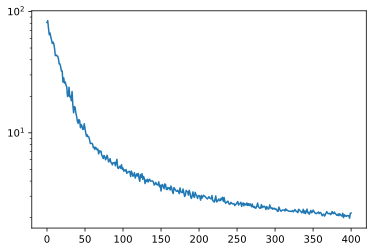

In [19]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
model = Model("studentt", "stable")
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
num_steps = 401
optim = ClippedAdam(lambda name, _: {
    "lr": 0.5 if name.startswith("Auto") else 0.02,
    "lrd": 0.1 ** (1 / num_steps),
})
svi = SVI(model, guide, optim, Trace_CRPS())
losses = []
for step in range(num_steps):
    loss = svi.step(r)
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))
add_prediction(model, guide, r)

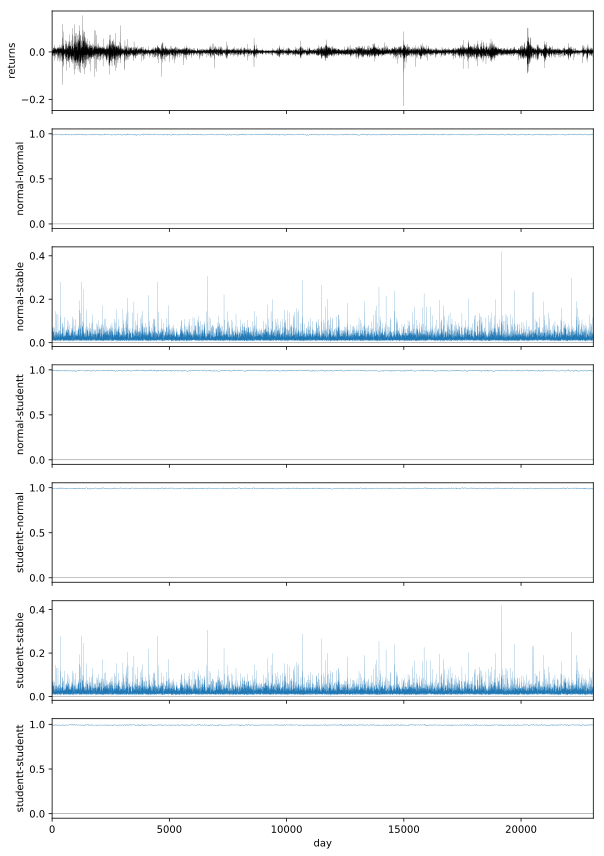

In [31]:
fig, axes = pyplot.subplots(1 + len(predictions), figsize=(8.5, 12), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("returns")
axes[0].set_xlim(0, len(r))
for key, ax in zip(sorted(predictions), axes[1:]):
    log_h, r_pred = predictions[key]
    ax.plot(log_h.mul(0.5).exp(), lw=0.2)
    ax.set_ylabel("-".join(key))
    ax.axhline(0, lw=0.5, color='gray')
ax.set_xlabel("day")
pyplot.tight_layout()